---
format: 
  html:
    toc: true
    number-sections: true
    code-fold: true
execute:
  echo: true
---

# Model Building, Validation, and Prediction

In this section, we developed and tested both a Poisson Regression model and a Random Forest model on the modeling dataset, using 2022/23 variables to predict 2023 complaint counts. The process involved splitting the data into test and training sets, setting up a pipeline for model training, calculating the coefficient of determination (R-squared) using a 5-fold cross-validation, and evaluating Mean Absolute Errors (MAEs) across DSNY unit-date pairs. 

Based on these evaluations, we selected the Poisson Regression model as the better option for predicting complaint count data and applied it to the prediction dataset, using 2023/24 variables to forecast 2024 counts.

## Set Up

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

from matplotlib import pyplot as plt
import hvplot.pandas

import requests

# Import the machine learning libraries
from sklearn.linear_model import PoissonRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# Set the random seed for reproducibility
np.random.seed(3)

# Show all columns
pd.options.display.max_columns = 999

## Load Master Data

In [2]:
DSNY_master = pd.read_parquet('data/2_DSNY_master.parquet')

### Select Interested Variables from the previous step

In [ ]:
DSNY_master_filtered = DSNY_master[["DSNY_ID", "Complaint Count", "Complaint Count Lag", "Pct_Non_White", "Pct_Hispanic",
                                  "Poverty_Rate", "Avg_HH_Size", "Restaurant Inspection Count", "Derelict Vehicle Count",
                                  "avg_temp", "Basket Count", "Traffic Count", "Holiday", "Week"]]

DSNY_master_filtered['Week'] = DSNY_master['Week'].astype(str)

### Additional Data Cleaning: Treating NAs Differently

For rows where the ACS (American Community Survey) or temperature fields contain NA, they are directly removed. This is because missing values in these fields do not necessarily indicate the absence of data; rather, they may result from unmeasured or unavailable data. Retaining such rows could introduce bias or inaccuracies, so removing them is a more prudent approach.

In [4]:
# remove rows if ACS or weather columns contain NAs
columns_to_check = ['Pct_Non_White', 'Pct_Hispanic', 'Poverty_Rate', 'Avg_HH_Size', 'avg_temp']

DSNY_master_filtered = DSNY_master_filtered.dropna(subset=columns_to_check)

For other fields (such as complaint, derelict vehicle, inspection, traffic, and basket), missing values (NA) are uniformly replaced with 0. This is because NA in these fields is more likely to indicate the absence of related events rather than missing data. Therefore, replacing NA with 0 to represent "no record" is more logical and appropriate.

In [5]:
# replace NAs with zeros for all other columns
columns_to_replace = ['Complaint Count', 'Complaint Count Lag', 'Restaurant Inspection Count', 'Derelict Vehicle Count', 'Basket Count', 'Traffic Count']

DSNY_master_filtered[columns_to_replace] = DSNY_master_filtered[columns_to_replace].fillna(0)

In [6]:
DSNY_master_filtered.head()

,DSNY_ID,Complaint Count,Complaint Count Lag,Pct_Non_White,Pct_Hispanic,Poverty_Rate,Avg_HH_Size,Restaurant Inspection Count,Derelict Vehicle Count,avg_temp,Basket Count,Traffic Count,Holiday,Week
0,BKN011_A,0.0,0.0,30.224904,13.878223,5.951728,2.11,0.0,0.0,10.1,47,9794.421906,False,52
1,BKN011_A,0.0,0.0,30.224904,13.878223,5.951728,2.11,0.0,0.0,11.5,47,9794.421906,False,1
2,BKN011_A,0.0,1.0,30.224904,13.878223,5.951728,2.11,0.0,0.0,1.2,47,9794.421906,False,1
3,BKN011_A,0.0,0.0,30.224904,13.878223,5.951728,2.11,0.0,0.0,-3.8,47,9794.421906,False,1
4,BKN011_A,0.0,0.0,30.224904,13.878223,5.951728,2.11,0.0,0.0,2.5,47,9794.421906,False,1


**Important Note:**

Next, we will proceed with model building using the 2023 master dataset. Since the complaint data is count-based, we selected Poisson Regression and Random Forest Regression as the two predictive models. By comparing the Mean Squared Error (MSE) and Mean Absolute Error (MAE) of the predictions from both models, we will choose the model with better performance to make predictions on the 2024 master dataset. In Section 5, we will propose some optimization recommendations for DSNY's Trash Collection Schedules based on the prediction results.

## Model Building I - Poisson Regression

We fitted and tested the initial Poisson Regression model on a 70/30 split of training and test datasets, consisting of randomly selected records from the master modeling dataset. The independent variables were chosen based on the correlation plots and spatial maps discussed in the previous section, along with additional variables believed to have significance in the literature (`Traffic Count`, `Holiday`, `Week`, and `DSNY_ID`, the DSNY unit's unique identifier). A pipeline was constructed to standardize the numerical variables (including all count features due to their significantly differing ranges), one-hot encode categorical variables, and fit to the dependent variable `Complaint Count`. The resulting model was then used to make predictions on the test dataset.

### Set Regression Features

In [7]:
X = DSNY_master_filtered[['Complaint Count Lag','Pct_Non_White', 'Pct_Hispanic', 'Poverty_Rate', 'Avg_HH_Size', 'avg_temp', 
        'Restaurant Inspection Count', 'Derelict Vehicle Count', 'Basket Count', 'Traffic Count', 'Holiday', 'Week', "DSNY_ID"]]
y = DSNY_master_filtered['Complaint Count']

### Set up a Pipeline

In [8]:
num_cols = [
    "Complaint Count Lag",
    "Pct_Non_White",
    "Pct_Hispanic",
    "Poverty_Rate",
    "Avg_HH_Size",
    "avg_temp",
    "Restaurant Inspection Count",
    "Derelict Vehicle Count",
    "Basket Count",
    "Traffic Count"
]

cat_cols = ["Holiday", "Week", "DSNY_ID"]

# Create transformer
transformer = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

# Initialize pipeline
pipe = make_pipeline(
    transformer, PoissonRegressor(alpha=1e-12, max_iter=1000))

### Split Test and Train Data

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)

# Save test indices for later extraction
test_indices = X_test.index

### Fit Model

In [10]:
model_1 = pipe.fit(X_train, y_train)

### Make Predictions

In [11]:
y_pred = pipe.predict(X_test)

### Model Evaluation

#### Cross Validation on Training Dataset

Using cross-validation, the model achieved an average R-squared of 0.12 (standard deviation: 0.011), indicating that approximately 12% of the variation in the dependent variable is explained by the independent variables. Comparing to a baseline model of mean of median, the model's R-squared of 0.12 indicates better prediction capability, as it explains 12% more of the variance. Nonetheless, we note that the R-squared could likely be improved with the inclusion of additional time-series data or more granular records that better capture the differentiation between DSNY units, such as foot-traffic or land use info.

In [12]:
# Perform 5-fold cross-validation
scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='r2')
print("Cross-validated R^2 scores:", scores)
print("Mean R^2:", scores.mean())
print("Standard deviation of R^2:", scores.std())

Cross-validated R^2 scores: [0.10121009 0.1237754  0.11564138 0.12658687 0.13295318]
Mean R^2: 0.12003338227646802
Standard deviation of R^2: 0.010931403584294239


#### Mean Squared / Absolute Error of Predicted Dataset

The Poisson Regression model has a Mean Squared Error (MSE) of 0.63 and a Mean Absolute Error (MAE) of 0.50.

In [13]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

Mean Squared Error: 0.6345969709762334
Mean Absolute Error: 0.4985336344940524


In [14]:
# Create a copy of X_test and add the original and predicted values
model1_results = X_test.copy()
model1_results['Original'] = y_test
model1_results['Predicted'] = y_pred

# Calculate the absolute error
model1_results['Absolute_Error'] = abs(model1_results['Predicted'] - model1_results['Original'])

#### Mapping MAEs: Model 1

We further joined the predicted results back to the test dataset to compute the absolute error for each unique DSNY unit-date pair. Then, we calculated the MAE for each DSNY unit and visualized the spatial distribution of MAEs in the following map. 

The results reveal significant spatial variation in model performance. The model tends to overpredict in areas such as Midtown Manhattan, the Bronx, parts of central Brooklyn, and southern Queens, where urban developments are denser and the original complaint counts are higher. In contrast, lower errors are observed in regions like southern Brooklyn and Staten Island, indicating better alignment between predicted and actual counts.

These differences suggest that the model performs better in areas with less variability in complaint patterns, while it struggles to accurately capture the dynamics of denser, high-activity urban zones.

In [15]:
# Import the DSNY boundary data
DSNY_boundary = gpd.read_file("data/1_DSNY_boundary_processed.geojson")
DSNY_boundary = DSNY_boundary.to_crs(epsg=2263)

In [16]:
# Group the model results by DSNY_ID and calculate the mean
model1_map_grouped = model1_results.groupby('DSNY_ID').mean()
model1_map_grouped = model1_map_grouped.reset_index()

model1_map_grouped.head()

C:\Users\ztyuu\AppData\Local\Temp\ipykernel_37864\219829265.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  model1_map_grouped = model1_results.groupby('DSNY_ID').mean()


,DSNY_ID,Complaint Count Lag,Pct_Non_White,Pct_Hispanic,Poverty_Rate,Avg_HH_Size,avg_temp,Restaurant Inspection Count,Derelict Vehicle Count,Basket Count,Traffic Count,Holiday,Original,Predicted,Absolute_Error
0,BKN011_A,0.627273,30.224904,13.878223,5.951728,2.11,12.866364,0.154545,0.181818,47.0,9794.421906,0.0,0.736364,0.713784,0.746283
1,BKN011_B,0.430894,38.286713,20.687646,11.324786,2.18,13.301626,0.113821,0.219512,49.0,8879.006680,0.0,0.658537,0.727300,0.678283
2,BKN012_A,0.642202,51.956912,36.140036,17.414722,2.19,12.802752,0.055046,0.137615,14.0,7402.500962,0.0,0.917431,1.301385,1.052745
3,BKN012_B,1.304348,39.505777,29.107831,20.699615,2.15,13.250435,0.339130,0.165217,97.0,8893.689957,0.0,1.817391,1.706644,1.286355
4,BKN013_A,0.959184,84.018415,24.991779,33.212759,2.82,12.941837,0.081633,0.214286,28.0,7246.675347,0.0,1.081633,1.084030,0.830075


In [17]:
# Join model1_map_grouped with DSNY_boundary
model1_map_grouped = DSNY_boundary.merge(
    model1_map_grouped, 
    left_on='DSNY_ID', 
    right_on='DSNY_ID'
)

model1_map_grouped = gpd.GeoDataFrame(model1_map_grouped, geometry='geometry')

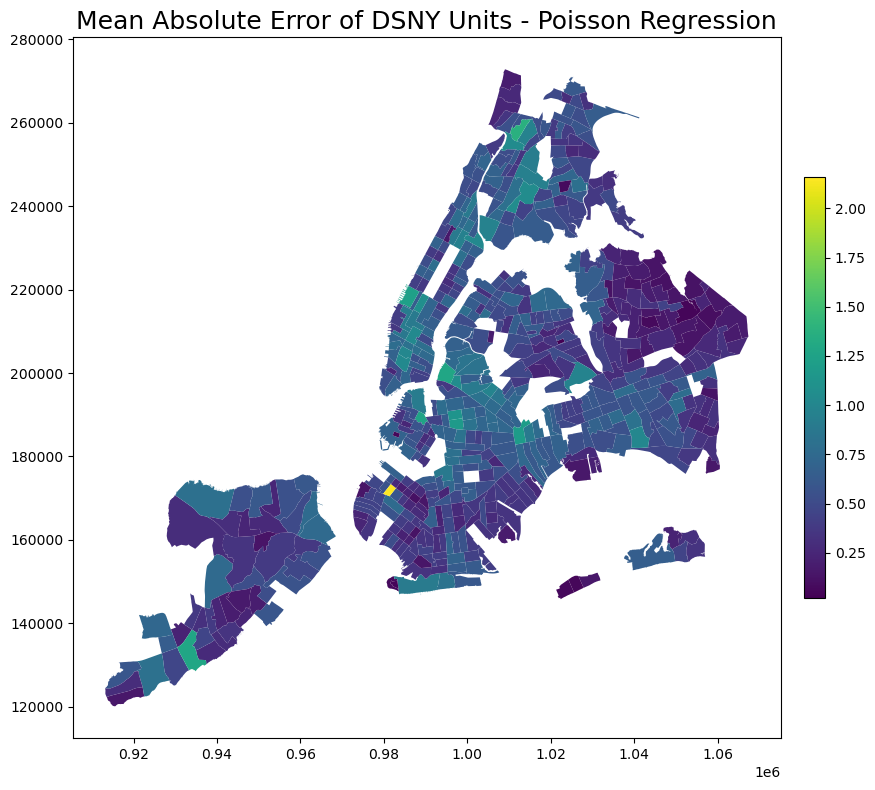

In [18]:
# Create a single plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the map based on Absolute_Error column
model1_map_grouped.plot(
    column='Absolute_Error',
    cmap="viridis",
    legend=True,
    ax=ax,
    legend_kwds={
        'shrink': 0.6,
        'location': 'right',
        'pad': 0.02,
        'aspect': 20
    }
)

# Set the title
ax.set_title("Mean Absolute Error of DSNY Units - Poisson Regression", fontsize=18)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## Model Building II - Random Forest Regression

### Set up a random forest pipeline

Next, we fitted and tested a second model - the Random Forest model - on the same 70/30 training and test datasets. We adjusted the pipeline from the previous step and replaced the prediction model to a Random Forest, with parameters n_estimators = 100 and max_depth non-specified. The resulting model was then used to make predictions on the test dataset.

In [19]:
rf_pipeline = make_pipeline(transformer, RandomForestRegressor(n_estimators=100, max_depth=None, n_jobs=-1, random_state=3))

### Fit the model

Use the 70% training data and 30% testing data split from the previous step.

In [20]:
model_2 = rf_pipeline.fit(X_train, y_train)

### Make Predictions

In [21]:
y_rf_pred = rf_pipeline.predict(X_test)

### Model Evaluation

#### Cross Validation on Training Dataset

Comparing to the Poisson Regression model, the Random Forest model performs significantly worse, as evidenced by an overall R-squared of -0.024. This poor performance is primarily due to one of the five folds obtaining an R-squared of -0.25, while the remaining four folds ranged between 0.008 and 0.055. The underperformance of the Random Forest model may be due to the relatively limited independent features, which might not provide enough diversity for a tree-based ensemble model to effectively partition and generalize the data.

In [22]:
# Use a 5-fold cross-validation
scores = cross_val_score(rf_pipeline, X_train, y_train, cv=5, scoring='r2')
print("Cross-validated R^2 scores:", scores)
print("Mean R^2:", scores.mean())
print("Standard deviation of R^2:", scores.std())

Cross-validated R^2 scores: [ 0.05532603  0.04083288  0.00802746  0.02453019 -0.2493868 ]
Mean R^2: -0.024134046619593997
Standard deviation of R^2: 0.11373300037068071


#### Mean Squared / Absolute Error of Predicted Dataset

Likewise, with aN MSE of 0.69 and an MAE OF 0.51, the Random Forest model also underperforms compared to the Poisson Regression model.

In [23]:
rf_mse = mean_squared_error(y_test, y_rf_pred)
rf_mae = mean_absolute_error(y_test, y_rf_pred)

print(f"Random Forest Mean Squared Error: {rf_mse}")
print(f"Random Forest Mean Absolute Error: {rf_mae}")

Random Forest Mean Squared Error: 0.6943296050519497
Random Forest Mean Absolute Error: 0.5082999457597058


#### Mapping MAEs: Model 2

Echoing the process completed for Model 1 (Poisson Regression), we joined the predicted results back to the test dataset to calculate the absolute error for each unique DSNY unit-date pair. We then computed the Mean Absolute Error (MAE) for each DSNY unit and visualized the spatial distribution of MAEs through mapping.

The map reveals similar spatial biases in model performance like Model 1, including apparent overprediction in areas of denser urban development and higher actual complaint counts (ie. Midtown Manhattan, the Bronx, parts of central Brooklyn, and southern Queens). Comparatively, lower errors are observed in regions like southern Brooklyn and Staten Island, indicating better match between predicted and actual counts. These similar observations highlight inherent limitations in the predictive features, leading to shared shortcomings across both models.

In [24]:
# Create a copy of X_test and add the original and predicted values
model2_results = X_test.copy()
model2_results['Original'] = y_test
model2_results['Predicted'] = y_rf_pred

# Calculate the absolute error
model2_results['Absolute_Error'] = abs(model2_results['Predicted'] - model2_results['Original'])

In [25]:
# Group the model results by DSNY_ID and calculate the mean
model2_map_grouped = model2_results.groupby('DSNY_ID').mean()
model2_map_grouped = model2_map_grouped.reset_index()

model2_map_grouped.head()

C:\Users\ztyuu\AppData\Local\Temp\ipykernel_37864\2418635244.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  model2_map_grouped = model2_results.groupby('DSNY_ID').mean()


,DSNY_ID,Complaint Count Lag,Pct_Non_White,Pct_Hispanic,Poverty_Rate,Avg_HH_Size,avg_temp,Restaurant Inspection Count,Derelict Vehicle Count,Basket Count,Traffic Count,Holiday,Original,Predicted,Absolute_Error
0,BKN011_A,0.627273,30.224904,13.878223,5.951728,2.11,12.866364,0.154545,0.181818,47.0,9794.421906,0.0,0.736364,0.741036,0.771545
1,BKN011_B,0.430894,38.286713,20.687646,11.324786,2.18,13.301626,0.113821,0.219512,49.0,8879.006680,0.0,0.658537,0.755989,0.735935
2,BKN012_A,0.642202,51.956912,36.140036,17.414722,2.19,12.802752,0.055046,0.137615,14.0,7402.500962,0.0,0.917431,1.155985,1.134884
3,BKN012_B,1.304348,39.505777,29.107831,20.699615,2.15,13.250435,0.339130,0.165217,97.0,8893.689957,0.0,1.817391,1.607022,1.311935
4,BKN013_A,0.959184,84.018415,24.991779,33.212759,2.82,12.941837,0.081633,0.214286,28.0,7246.675347,0.0,1.081633,1.117143,0.948571


In [26]:
# Join model2_map_grouped with DSNY_boundary
model2_map_grouped = DSNY_boundary.merge(
    model2_map_grouped, 
    left_on='DSNY_ID', 
    right_on='DSNY_ID'
)

model2_map_grouped = gpd.GeoDataFrame(model2_map_grouped, geometry='geometry')

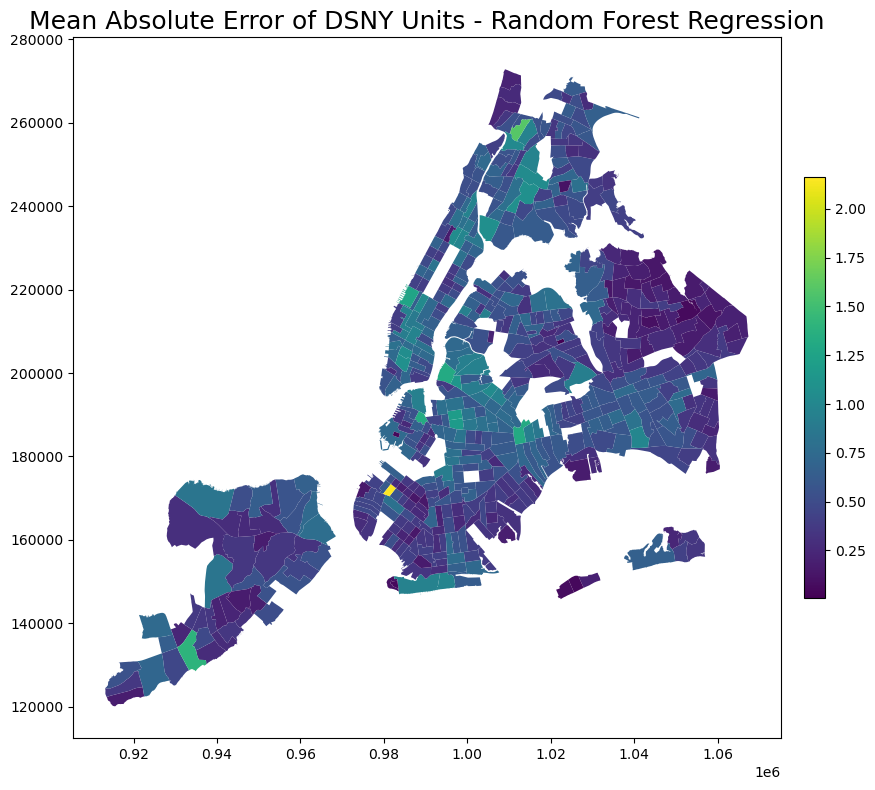

In [27]:
# Create a single plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the map based on Absolute_Error column
model2_map_grouped.plot(
    column='Absolute_Error',
    cmap="viridis",
    legend=True,
    ax=ax,
    legend_kwds={
        'shrink': 0.6,
        'location': 'right',
        'pad': 0.02,
        'aspect': 20
    }
)

# Set the title
ax.set_title("Mean Absolute Error of DSNY Units - Random Forest Regression", fontsize=18)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## Predict 2024 Results

Through model evaluation and performance comparison, we found that Poisson Regression exhibited significantly better predictive performance than Random Forest Regression. Consequently, Poisson Regression was chosen as the modeling method to predict the number of sanitation complaints for 2024.

### Load 2024 Data

In [29]:
DSNY_2024_master = pd.read_parquet("data/4_DSNY_pred_master.parquet")

### Process 2024

For rows where the ACS (American Community Survey) or temperature fields contain NA, they are directly removed. This is because missing values in these fields do not necessarily indicate the absence of data; rather, they may result from unmeasured or unavailable data. Retaining such rows could introduce bias or inaccuracies, so removing them is a more prudent approach.

In [30]:
# remove rows if ACS or weather columns contain NAs
columns_to_check_new = ['Pct_Non_White', 'Pct_Hispanic', 'Poverty_Rate', 'Avg_HH_Size', 'avg_temp']

DSNY_2024_master_filtered = DSNY_2024_master.dropna(subset=columns_to_check_new)

For other fields (such as complaint, derelict vehicle, inspection, traffic, and basket), missing values (NA) are uniformly replaced with 0. This is because NA in these fields is more likely to indicate the absence of related events rather than missing data. Therefore, replacing NA with 0 to represent "no record" is more logical and appropriate.

In [ ]:
# replace NAs with zeros for all other columns
columns_to_replace_new = ['Complaint Count Lag', 'Restaurant Inspection Count', 'Derelict Vehicle Count', 'Basket Count', 'Traffic Count']

DSNY_2024_master_filtered[columns_to_replace_new] = DSNY_2024_master_filtered[columns_to_replace_new].fillna(0)

### Use the Better-Fit Model to Predict 2024 Results

In [ ]:
X_new = DSNY_2024_master_filtered[['Complaint Count Lag','Pct_Non_White', 'Pct_Hispanic', 'Poverty_Rate', 'Avg_HH_Size', 'avg_temp', 
        'Restaurant Inspection Count', 'Derelict Vehicle Count', 'Basket Count', 'Traffic Count', 'Holiday', 'Week', "DSNY_ID"]]

X_new["Week"] = X_new["Week"].astype(str) 
X_new["DSNY_ID"] = X_new["DSNY_ID"].astype(str)

In [33]:
y_new = model_1.predict(X_new)

### Save Prediction Results

In [34]:
predicted_results_2024 = DSNY_2024_master_filtered.copy()
predicted_results_2024['Predicted'] = y_new

In [35]:
predicted_results_2024.to_parquet('data/predicted_results_2024.parquet', index=False)